<a href="https://colab.research.google.com/github/emgifford/NYC-Deaths-Dataset-/blob/main/NYC_Cause_of_Death_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Emily Gifford's EDA NYC Cause of Death Analysis Project**

**Context:**
New York City collects the leading causes of death by sex and ethnicity in New York City annually (since 2007) but only goes up to 2019. Cause of death is derived from the NYC death certificate which is issued for every death that occurs in New York City.

**Objective:**
The data contains the different attributes relating to cause of death. The goal of this is to engage in Exploratory Data Analysis and using univariate and bivariate analysis to conduct observations. 

**The data dictionary is below:**

**Year:** The year of death.

**Sex:** The decedent's sex.

**Race Ethnicity:** The decedent's ethnicity.

**Deaths:** The number of people who died due to cause of death.

**Death Rate:** The death rate within the sex and Race/ethnicity category.

**Age Adjusted Death Rate:** The age-adjusted death rate within the sex and Race/ethnicity category


In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#allowing google colab 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Projects for Resume/NYC Death Records Clustering Ensemble Techniques/New_York_City_Leading_Causes_of_Death.csv")

##**Sanity Checks/Overview**

In [ ]:
data.head()
#checking top 5 rows/columns 

,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
0,2011,Chronic Lower Respiratory Diseases (J40-J47),M,White Non-Hispanic,444,33.3,27.8
1,2008,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3361,250.4,214.3
2,2010,"Chronic Liver Disease and Cirrhosis (K70, K73)",M,Hispanic,150,13.1,17.6
3,2014,Malignant Neoplasms (Cancer: C00-C97),M,Hispanic,1146,96,143.5
4,2014,Certain Conditions originating in the Perinata...,M,Not Stated/Unknown,25,.,.


In [ ]:
data.tail()
#checking bottom 5 rows/columns 

,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
1798,2017,"Chronic Liver Disease and Cirrhosis (K70, K73-...",Male,Other Race/ Ethnicity,2,NaN,NaN
1799,2017,Aortic Aneurysm and Dissection (I71),Male,Other Race/ Ethnicity,2,NaN,NaN
1800,2017,Alzheimer's Disease (G30),Male,Other Race/ Ethnicity,2,NaN,NaN
1801,2017,Septicemia (A40-A41),Male,Other Race/ Ethnicity,2,NaN,NaN
1802,2017,All Other Causes,Male,Other Race/ Ethnicity,16,NaN,NaN


Looks like there are some missing values for rate... 

In [ ]:
#checking shape of data 
data.shape

(1803, 7)

1803 rows, 7 columns 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Year                     1803 non-null   int64 
 1   Leading Cause            1803 non-null   object
 2   Sex                      1803 non-null   object
 3   Race Ethnicity           1803 non-null   object
 4   Deaths                   1803 non-null   object
 5   Death Rate               1582 non-null   object
 6   Age Adjusted Death Rate  1582 non-null   object
dtypes: int64(1), object(6)
memory usage: 98.7+ KB


Looks like some numbers are characterized as object--i.e. deaths--should be changed to numerical/NaN. Others like Age Adjusted seem to be not listed on some of the rows. 

Death Rate and Deaths need to be changed to numerical. 

Maybe there are missing values as seen by the lesser number of rows in death rate and age adjusted death rate 

In [ ]:
#sample of the data
data.sample(n=10, random_state=1)

,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
1413,2015,All Other Causes,Female,Non-Hispanic Black,1599,152.96561,129.51257133
962,2010,Malignant Neoplasms (Cancer: C00-C97),M,Black Non-Hispanic,1540,180.9,224.1
705,2007,Atherosclerosis (I70),F,Other Race/ Ethnicity,.,.,.
573,2007,"Diseases of Heart (I00-I09, I11, I13, I20-I51)",M,Other Race/ Ethnicity,36,.,.
1302,2019,"Accidents Except Drug Poisoning (V01-X39, X43,...",Male,Not Stated/Unknown,19,23.36850909,34.08958477
1533,2016,All Other Causes,Female,Asian and Pacific Islander,385,58.903627545,60.884572245
181,2009,"Diseases of Heart (I00-I09, I11, I13, I20-I51)",F,White Non-Hispanic,6297,438.3,226.2
1674,2017,Essential Hypertension and Renal Diseases (I10...,Female,Asian and Pacific Islander,60,8.8939485574,8.2733243648
1359,2019,Parkinson's Disease (G20),Female,Other Race/ Ethnicity,1,NaN,NaN
194,2012,Chronic Lower Respiratory Diseases (J40-J47),M,White Non-Hispanic,352,26.3,21.8


It appears that "." is needing to be changed to NaN; Also Sex seems to have features that need to be consolidated.

In [ ]:
#copying the data to another variable to avoid any changes to original data
df = data.copy()

In [ ]:
#checking for null values
df.isnull().sum()

Year                         0
Leading Cause                0
Sex                          0
Race Ethnicity               0
Deaths                       0
Death Rate                 221
Age Adjusted Death Rate    221
dtype: int64

Death Rate and Age have missing values--also have some object values that need to be changed. 

**Data Cleansing**

In [ ]:
df1=df.replace('.', np.NaN)
#replacing "." with NaN for easier analysis in a new dataset 

In [ ]:
df1.head()
#checking to see if replace went through on first glance

,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
0,2011,Chronic Lower Respiratory Diseases (J40-J47),M,White Non-Hispanic,444,33.3,27.8
1,2008,Malignant Neoplasms (Cancer: C00-C97),M,White Non-Hispanic,3361,250.4,214.3
2,2010,"Chronic Liver Disease and Cirrhosis (K70, K73)",M,Hispanic,150,13.1,17.6
3,2014,Malignant Neoplasms (Cancer: C00-C97),M,Hispanic,1146,96,143.5
4,2014,Certain Conditions originating in the Perinata...,M,Not Stated/Unknown,25,NaN,NaN


In [ ]:
#checking for null values
df1.isnull().sum()

Year                         0
Leading Cause                0
Sex                          0
Race Ethnicity               0
Deaths                     138
Death Rate                 607
Age Adjusted Death Rate    607
dtype: int64

In [ ]:
#checking for duplicate values
df1.duplicated().sum()

0

No duplicated values. 

In [ ]:
#checking to find uniqueness 
df1.nunique()

Year                        13
Leading Cause               36
Sex                          4
Race Ethnicity               8
Deaths                     632
Death Rate                 911
Age Adjusted Death Rate    913
dtype: int64

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Year                     1803 non-null   int64 
 1   Leading Cause            1803 non-null   object
 2   Sex                      1803 non-null   object
 3   Race Ethnicity           1803 non-null   object
 4   Deaths                   1665 non-null   object
 5   Death Rate               1196 non-null   object
 6   Age Adjusted Death Rate  1196 non-null   object
dtypes: int64(1), object(6)
memory usage: 98.7+ KB


In [ ]:
#converting Deaths, Death Rate, and Age Adjusted Death Rate to numerical 
df1['Deaths'] = pd.to_numeric(df1['Deaths'])
df1['Death Rate'] = pd.to_numeric(df1['Death Rate'])
df1['Age Adjusted Death Rate'] = pd.to_numeric(df1['Age Adjusted Death Rate'])

In [ ]:
df1.info()
#successful change to float 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     1803 non-null   int64  
 1   Leading Cause            1803 non-null   object 
 2   Sex                      1803 non-null   object 
 3   Race Ethnicity           1803 non-null   object 
 4   Deaths                   1665 non-null   float64
 5   Death Rate               1196 non-null   float64
 6   Age Adjusted Death Rate  1196 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 98.7+ KB


In [ ]:
df1.isnull().sum()

Year                         0
Leading Cause                0
Sex                          0
Race Ethnicity               0
Deaths                     138
Death Rate                 607
Age Adjusted Death Rate    607
dtype: int64

for Death Rate and Age Adjusted Death Rate, 607/1803 is around 33.67% of the data, too high won't impute. 

Deaths is 138/1803 which is around 7.65%--could impute, but will view first without imputing by median. 

**Sex Data Cleaning**

F and Female and M and Male are both in the dataframe seperately, they need to fixed to be one or the other and not as messy. 

In [ ]:
cleanup_sex = {"Sex": {"F": "Female", "M": "Male"}}

In [ ]:
df2 = df1.replace(cleanup_sex)
df2.head()

,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
0,2011,Chronic Lower Respiratory Diseases (J40-J47),Male,White Non-Hispanic,444.00000,33.30000,27.80000
1,2008,Malignant Neoplasms (Cancer: C00-C97),Male,White Non-Hispanic,3361.00000,250.40000,214.30000
2,2010,"Chronic Liver Disease and Cirrhosis (K70, K73)",Male,Hispanic,150.00000,13.10000,17.60000
3,2014,Malignant Neoplasms (Cancer: C00-C97),Male,Hispanic,1146.00000,96.00000,143.50000
4,2014,Certain Conditions originating in the Perinata...,Male,Not Stated/Unknown,25.00000,NaN,NaN


In [ ]:
#sample of the data
df2.sample(n=10, random_state=1)

,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
1413,2015,All Other Causes,Female,Non-Hispanic Black,1599.00000,152.96561,129.51257
962,2010,Malignant Neoplasms (Cancer: C00-C97),Male,Black Non-Hispanic,1540.00000,180.90000,224.10000
705,2007,Atherosclerosis (I70),Female,Other Race/ Ethnicity,NaN,NaN,NaN
573,2007,"Diseases of Heart (I00-I09, I11, I13, I20-I51)",Male,Other Race/ Ethnicity,36.00000,NaN,NaN
1302,2019,"Accidents Except Drug Poisoning (V01-X39, X43,...",Male,Not Stated/Unknown,19.00000,23.36851,34.08958
1533,2016,All Other Causes,Female,Asian and Pacific Islander,385.00000,58.90363,60.88457
181,2009,"Diseases of Heart (I00-I09, I11, I13, I20-I51)",Female,White Non-Hispanic,6297.00000,438.30000,226.20000
1674,2017,Essential Hypertension and Renal Diseases (I10...,Female,Asian and Pacific Islander,60.00000,8.89395,8.27332
1359,2019,Parkinson's Disease (G20),Female,Other Race/ Ethnicity,1.00000,NaN,NaN
194,2012,Chronic Lower Respiratory Diseases (J40-J47),Male,White Non-Hispanic,352.00000,26.30000,21.80000


In [ ]:
df2.value_counts("Sex")

Sex
Female    910
Male      893
dtype: int64

Sex consolidated. 

**Race Ethnicity Data Cleanup** 

Race Ethnicity data is messy and also needs consolidation. White Non-Hispanic and Black Non-Hispanic and Other all need titles consolidated. 

In [ ]:
cleanup_ethnicity = {"Race Ethnicity": {"Non-Hispanic Black": "Black Non-Hispanic", "Non-Hispanic White": "White Non-Hispanic"}}

In [ ]:
df3 = df2.replace(cleanup_ethnicity)
df3.head()

,Year,Leading Cause,Sex,Race Ethnicity,Deaths,Death Rate,Age Adjusted Death Rate
0,2011,Chronic Lower Respiratory Diseases (J40-J47),Male,White Non-Hispanic,444.00000,33.30000,27.80000
1,2008,Malignant Neoplasms (Cancer: C00-C97),Male,White Non-Hispanic,3361.00000,250.40000,214.30000
2,2010,"Chronic Liver Disease and Cirrhosis (K70, K73)",Male,Hispanic,150.00000,13.10000,17.60000
3,2014,Malignant Neoplasms (Cancer: C00-C97),Male,Hispanic,1146.00000,96.00000,143.50000
4,2014,Certain Conditions originating in the Perinata...,Male,Not Stated/Unknown,25.00000,NaN,NaN


##**Statistical Summary**

In [ ]:
df3.describe().T
#overview of stat summary of numerical values 

,count,mean,std,min,25%,50%,75%,max
Year,1803.00000,2013.04770,3.76752,2007.00000,2010.00000,2013.00000,2016.00000,2019.00000
Deaths,1665.00000,418.83303,824.91981,1.00000,26.00000,138.00000,300.00000,7050.00000
Death Rate,1196.00000,54.03261,74.38446,2.40000,12.46979,19.33032,70.27500,491.40000
Age Adjusted Death Rate,1196.00000,52.79896,68.45140,2.50000,11.99045,19.64318,79.27600,549.65937


**Categorical/Non-numerical Summary**

In [ ]:
#summary of categorical/non-numerical values
df3.describe(include='object').T

,count,unique,top,freq
Leading Cause,1803,36,Malignant Neoplasms (Cancer: C00-C97),156
Sex,1803,2,Female,910
Race Ethnicity,1803,6,Other Race/ Ethnicity,340


##**Exploratory Data Analysis (EDA)**

**Univariate Analysis of Numerical Values**

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(df3, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df3, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df3, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df3, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df3[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df3[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

**Year**

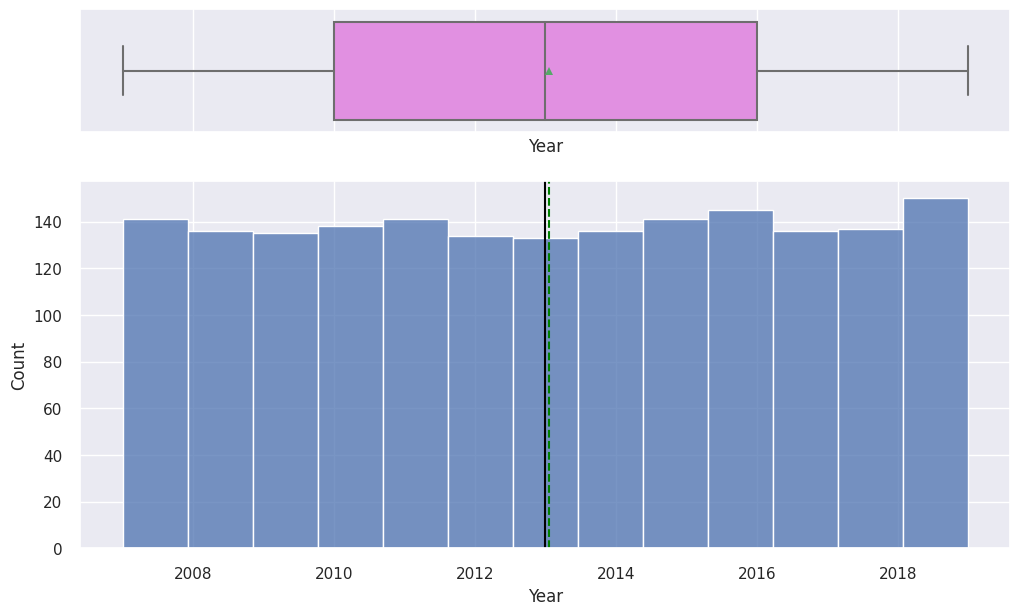

In [ ]:
histogram_boxplot(df3, 'Year')

Pretty uniform distribution. Makes sense since this is a categorial value. 

**Deaths**

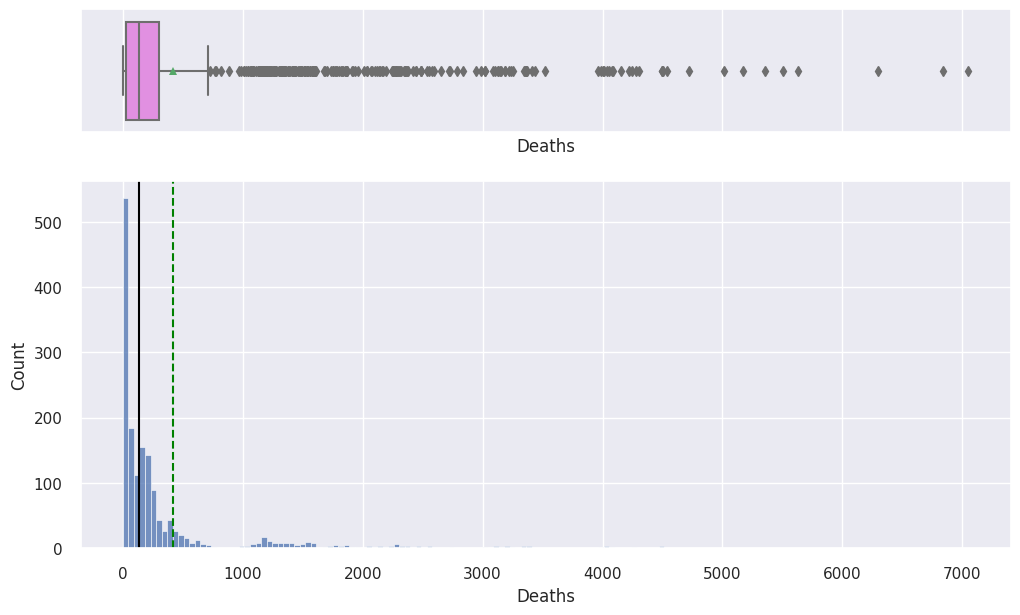

In [ ]:
histogram_boxplot(df3, 'Deaths')

Lots of outliers, very much right skewed. 

**Death Rate**

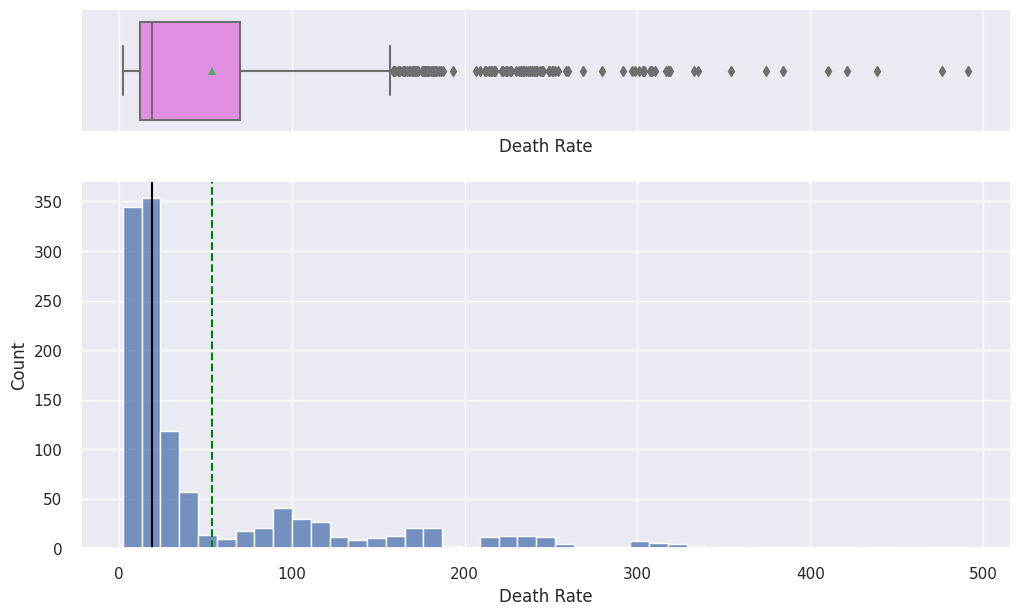

In [ ]:
histogram_boxplot(df3, 'Death Rate')

Right skewed, lots of outliers. 

**Age Adjusted Death Rate**

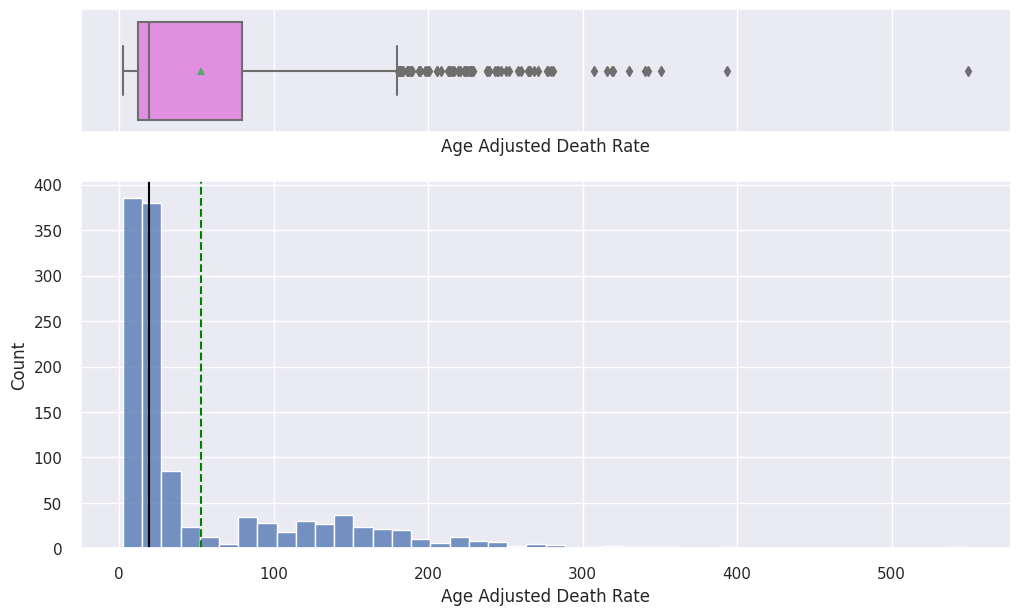

In [ ]:
histogram_boxplot(df3, 'Age Adjusted Death Rate')

Right skewed. Lots of outliers. 

**Categorical Data Univariate Analysis**

In [ ]:
# function to create labeled barplots


def labeled_barplot(df3, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(df3[feature])  # length of the column
    count = df3[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=df3,
        x=feature,
        palette="Paired",
        order=df3[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

**Leading Cause**

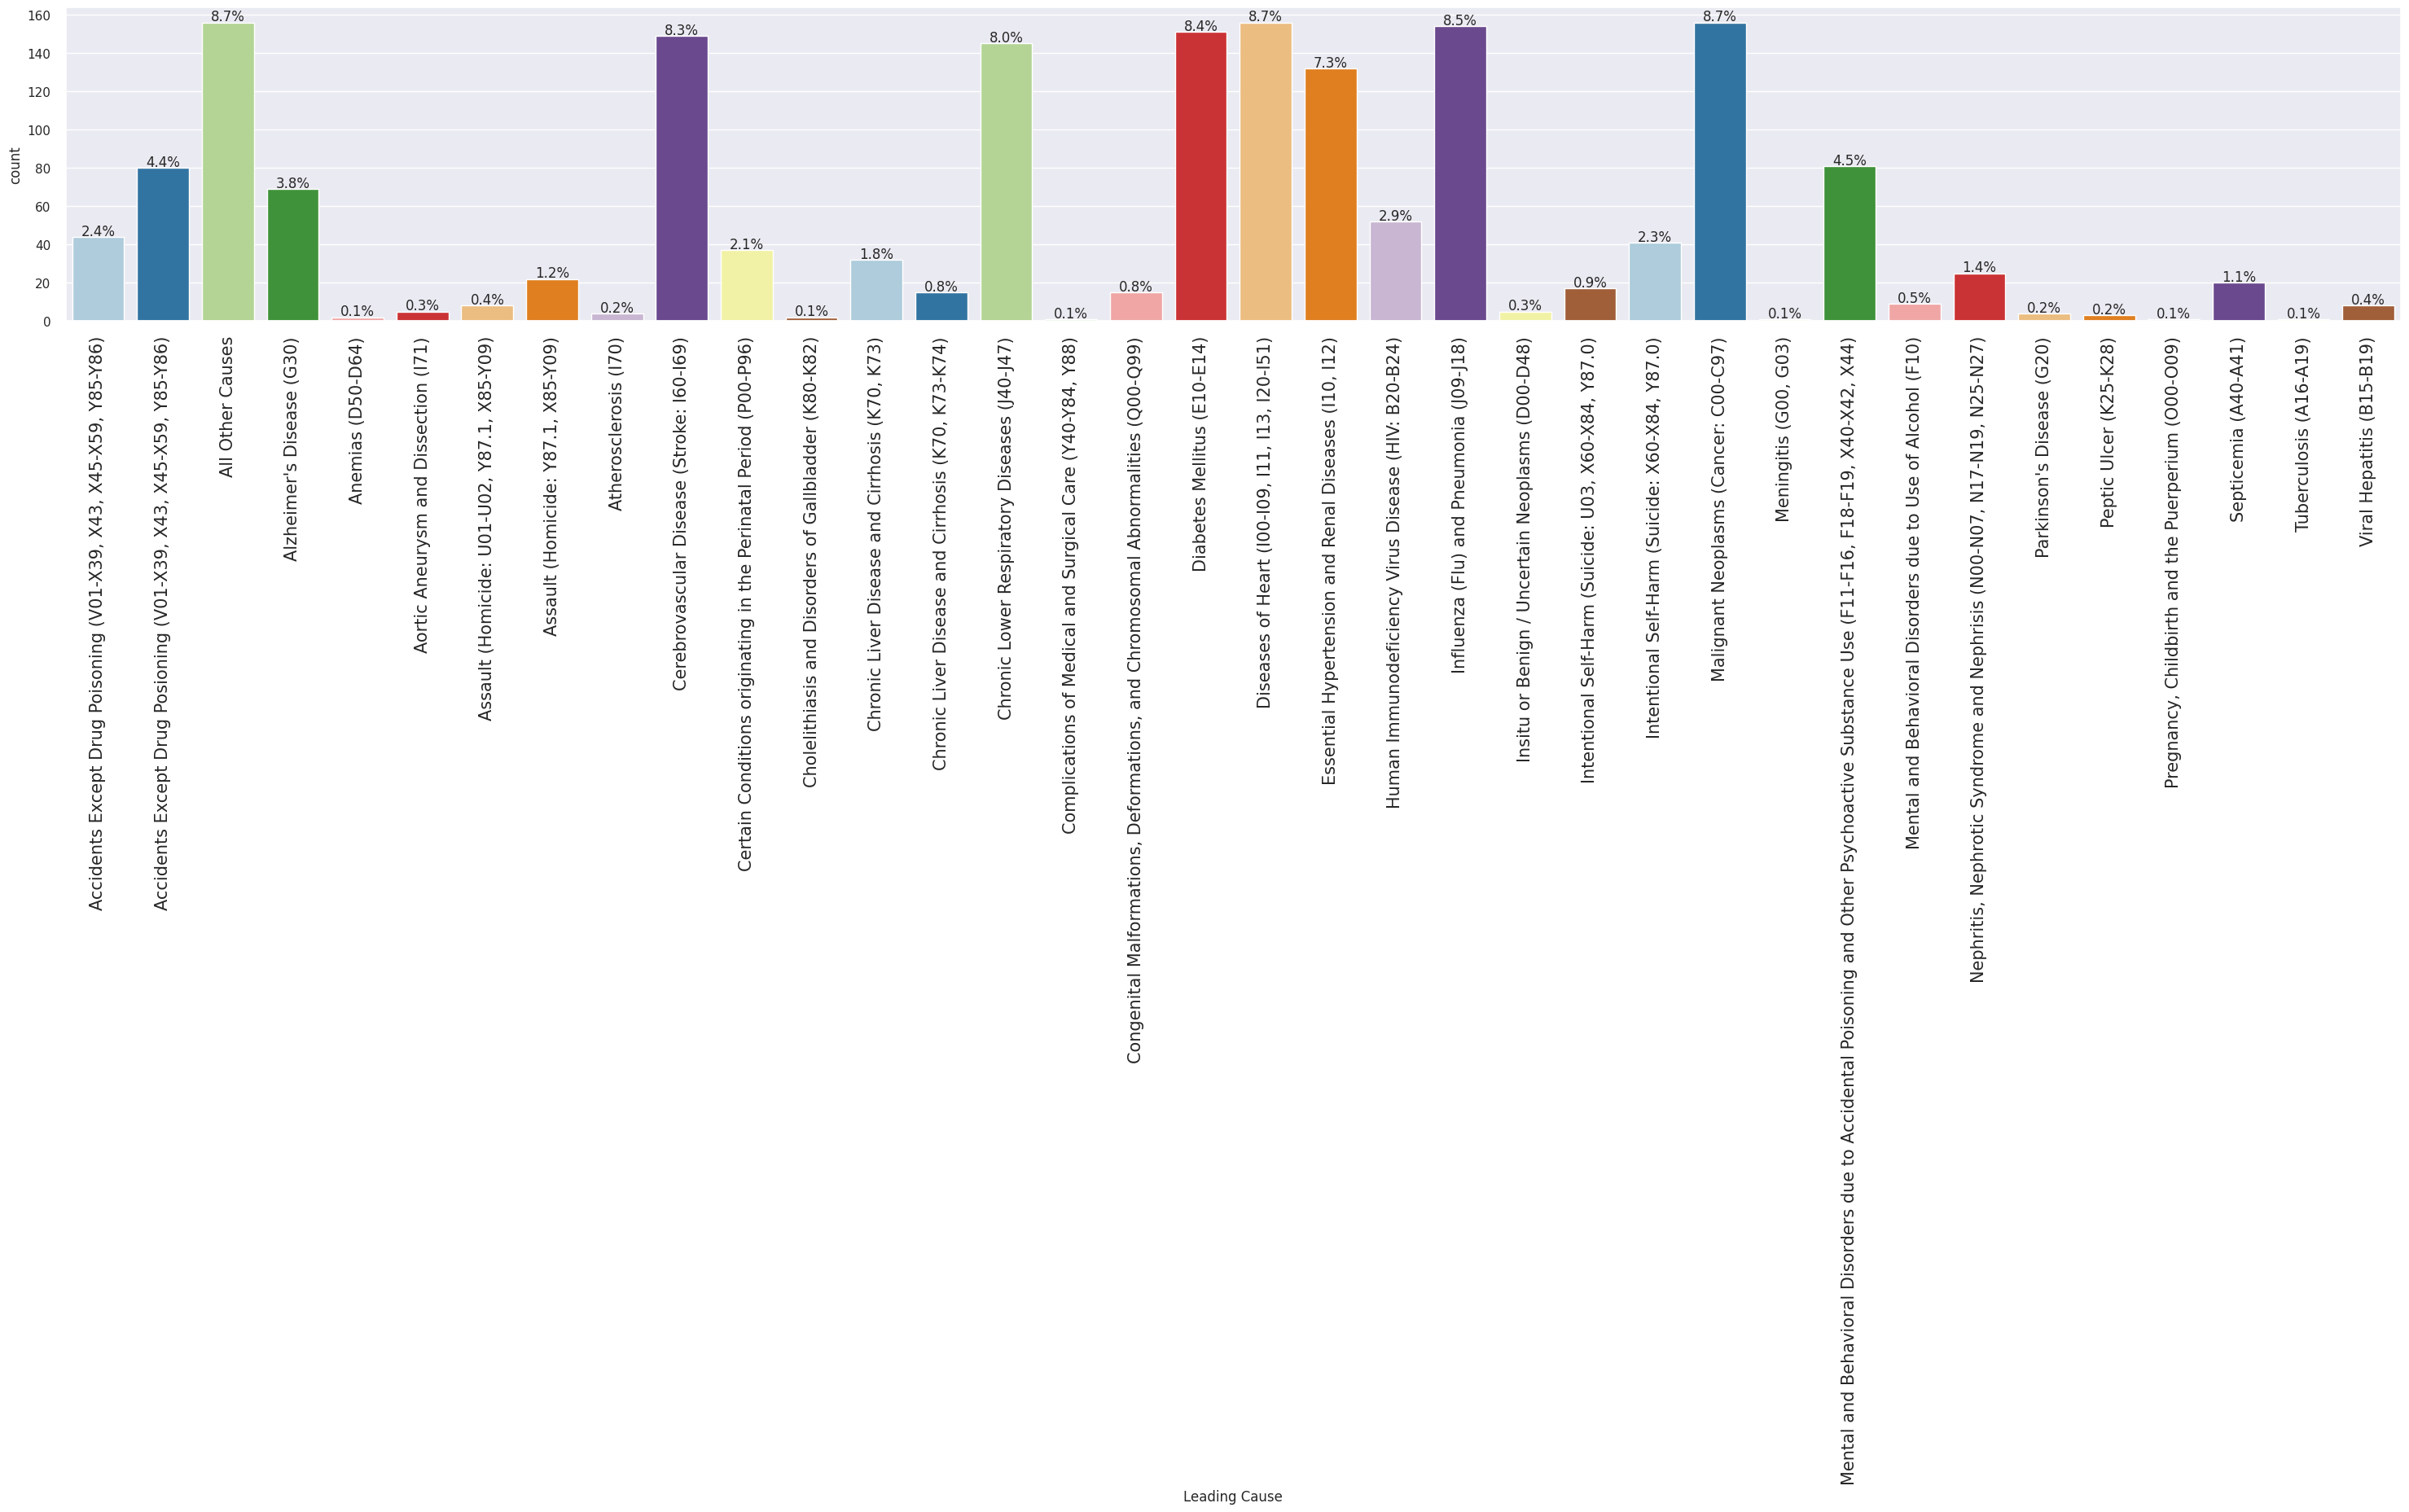

In [ ]:
labeled_barplot(df3, 'Leading Cause', perc=True)

According to summary and this bar graph: Malignant Neoplasms (Cancer: C00-C97) appears to have the most deaths at 8.7%. Also tied closey with All Other Causes (8.7%) and Diseases of the Heart (8.7%).

Then at 8.5% we have Influenza (Flu) and Pneumonia.

Minimum death percentages are Anemias (0.1%), Complications of Medical and Surgical Care (0.1%), Meningitis (0.1%), and Pregnancy, Childbirth, Puerperium (0.1%), Tuberculosis (0.1%).

**Sex**

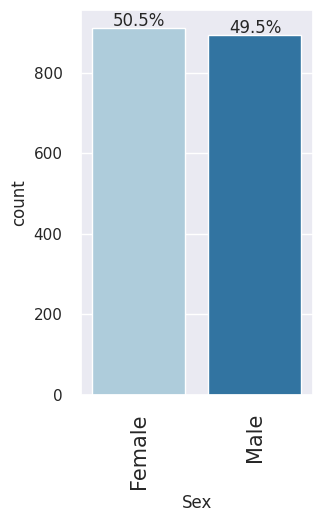

In [ ]:
labeled_barplot(df3, 'Sex', perc=True)

More female death rates in NYC by just a little bit (50.5%); nearly equal though, but less male at 49.5%.

**Race Ethnicity**

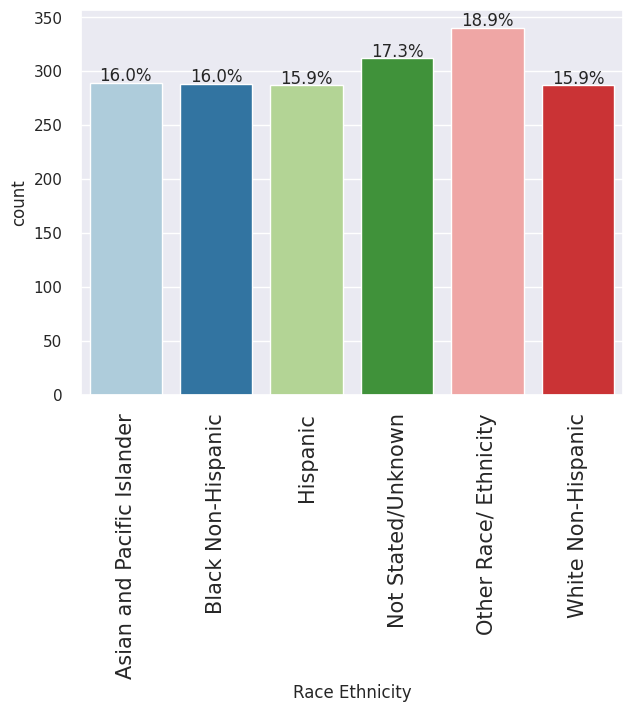

In [ ]:
labeled_barplot(df3, 'Race Ethnicity', perc=True)

Other Race/Ethnicity has the highest deaths (18.9%), followed closely by Not Stated/Unknown (17.3%) (This unknown category warrants further review/investigation). 

**Bivariate Analysis**

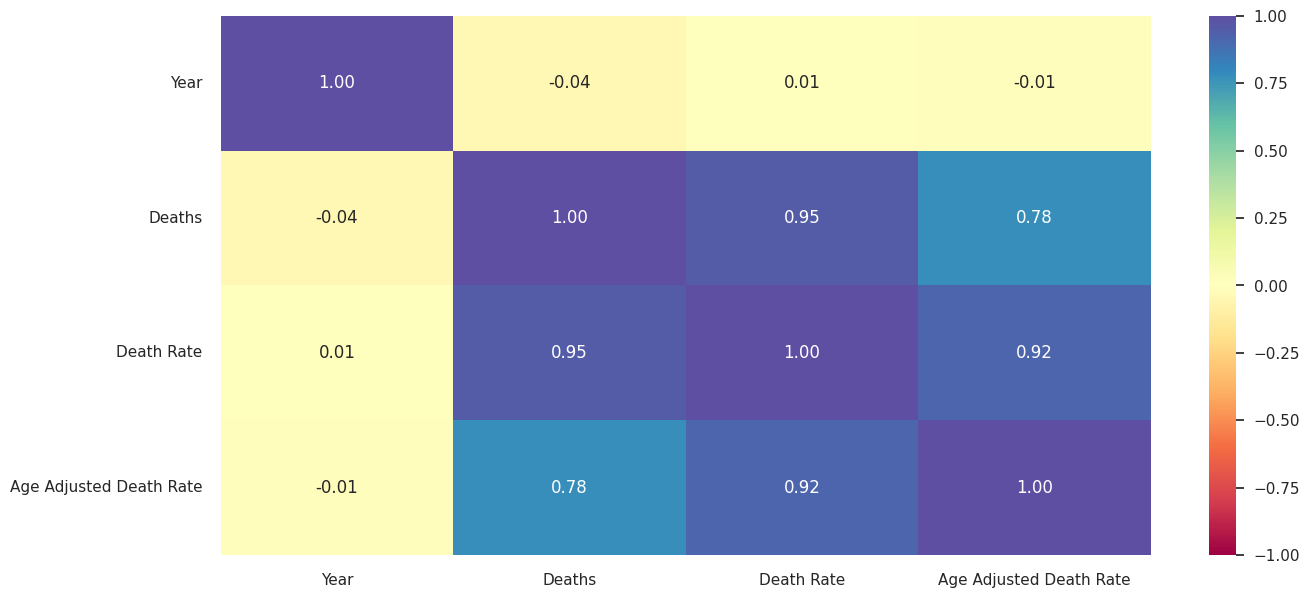

In [ ]:
# correlation check
plt.figure(figsize=(15, 7))
sns.heatmap(
    df3.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

Death Rate and Age Adjusted Death Rate are highly positively correlated at .92--as Age Adjusted Death Rate goes up, so does Death Rate (which makes sense).

Deaths and Age Adjusted Death Rate are also highly positively correlated at .78. 

Other than the two mentioned, there are no more notable correlations in this heat map. 



In [ ]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = df3[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=df3[df3[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=df3[df3[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=df3, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=df3,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [ ]:
def stacked_barplot(df3, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = df3[predictor].nunique()
    sorter = df3[target].value_counts().index[-1]
    tab1 = pd.crosstab(df3[predictor], df3[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(df3[predictor], df3[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

**Leading Cause and Sex**

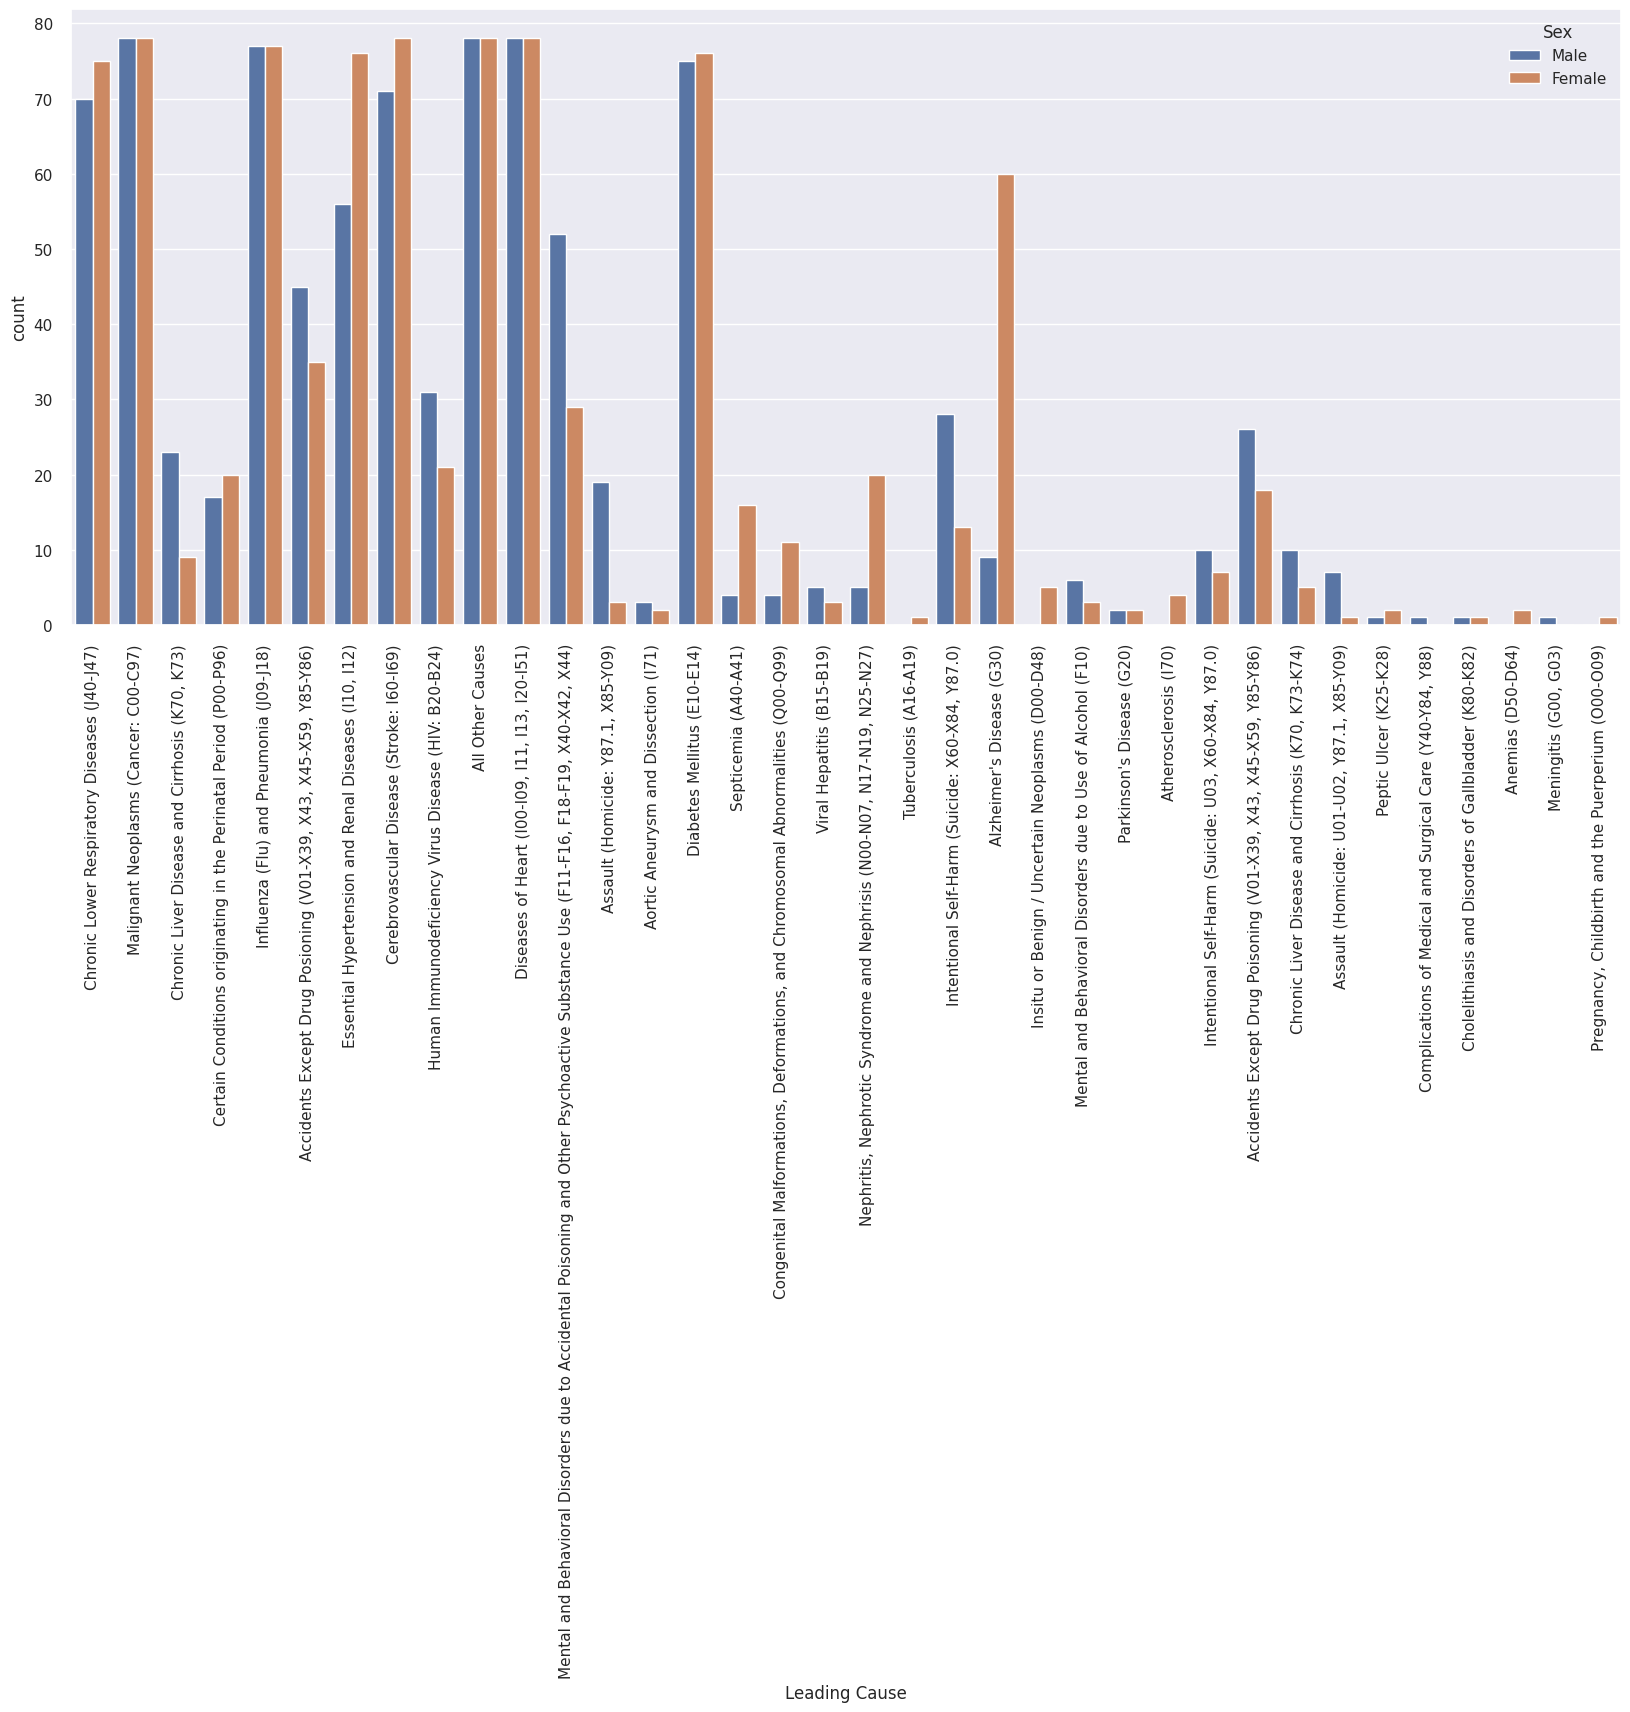

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data=df3, x='Leading Cause', hue='Sex')
plt.xticks(rotation=90)
plt.show()

Leading Cause  Accidents Except Drug Poisoning (V01-X39, X43, X45-X59, Y85-Y86)  \
Sex                                                                               
Female                                                        18                  
All                                                           44                  
Male                                                          26                  

Leading Cause  Accidents Except Drug Posioning (V01-X39, X43, X45-X59, Y85-Y86)  \
Sex                                                                               
Female                                                        35                  
All                                                           80                  
Male                                                          45                  

Leading Cause  All Other Causes  Alzheimer's Disease (G30)  Anemias (D50-D64)  \
Sex                                                                             
Female

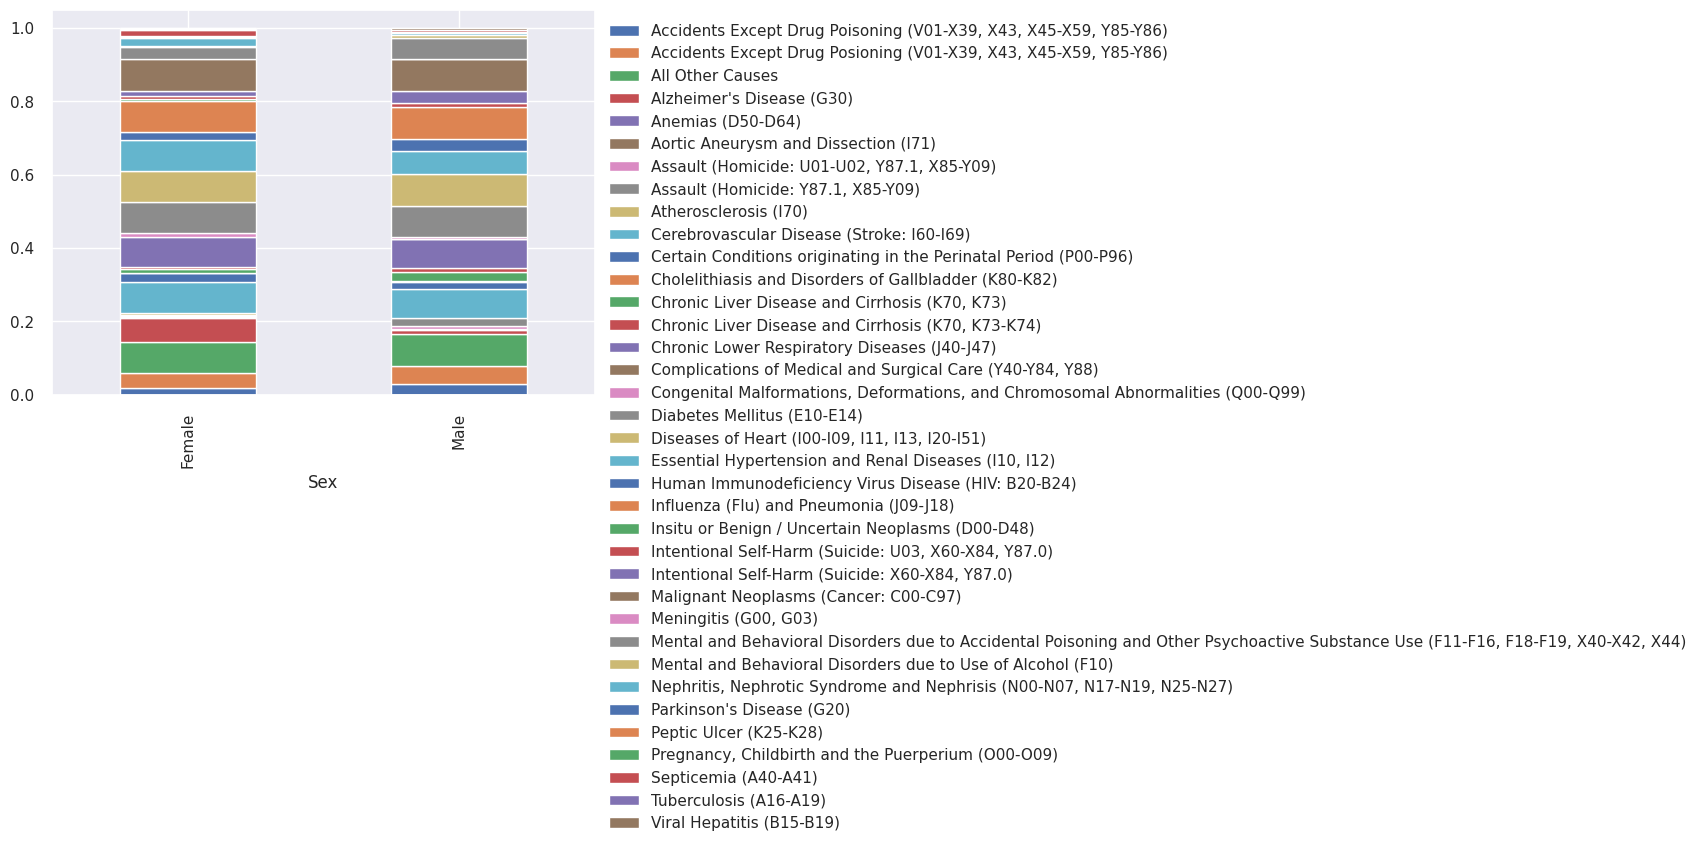

In [ ]:
stacked_barplot(df3, "Sex", "Leading Cause")

There are some notable disparities between sex and leading cause of death. Alzheimer's Disease seems to be a higher Leading Cause than in men. And unsurprisingly pregnancy related are only seen in the female sex. 

Some leading causes seem to be equal though: i.e. Leading Cause  Malignant Neoplasms (Cancer: C00-C97), Diseases of the Heart, Influensa (Flu), and All other causes. 

Alzheimer's Disease seems to be a higher Leading Cause than in men along with homicide. 

**Race Ethnicity and Deaths**

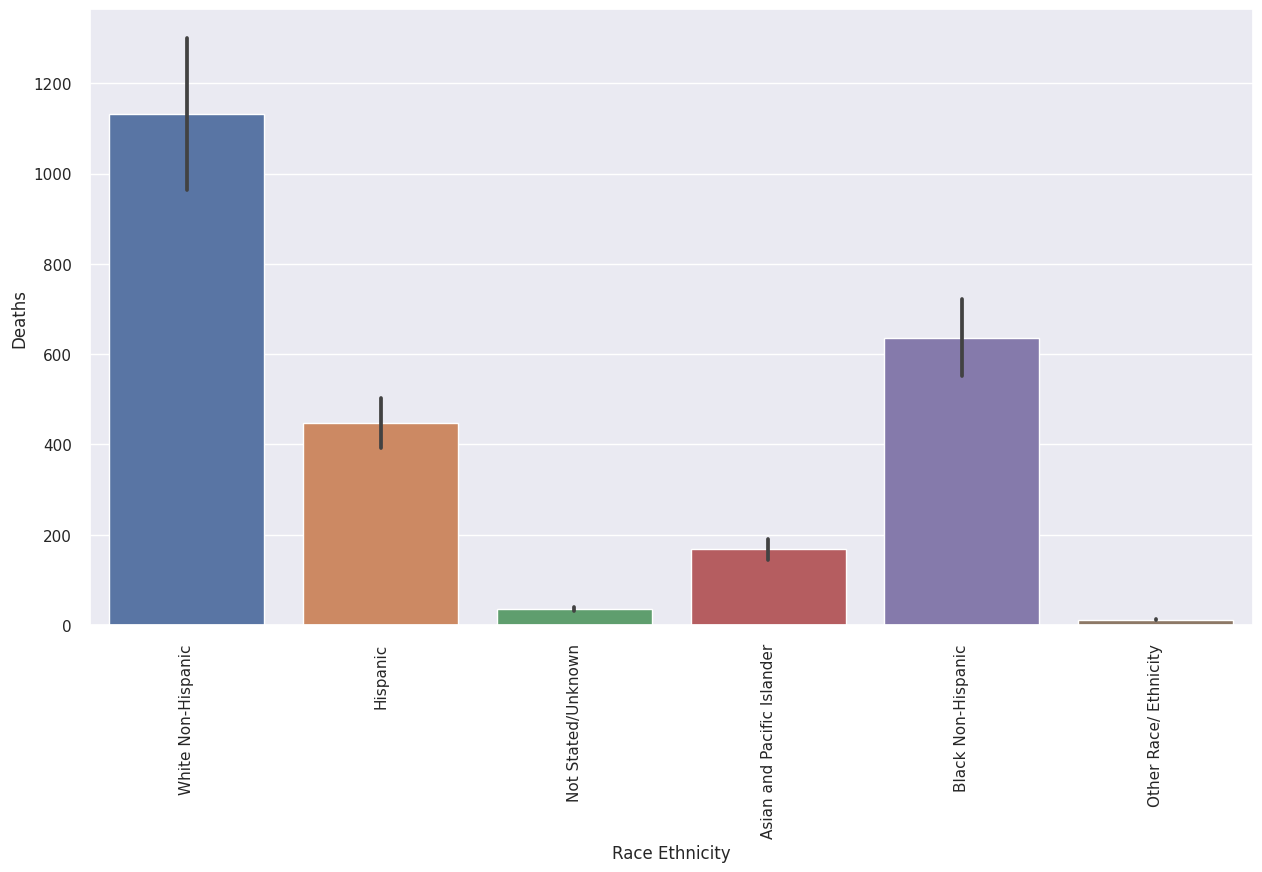

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data=df3, x='Race Ethnicity', y='Deaths')
plt.xticks(rotation=90)
plt.show()

White non-hispanic has the most deaths. Followed by black non-hispanic. 
Other race/ethnicity has the least amunt of deaths. 

**Sex and Deaths**

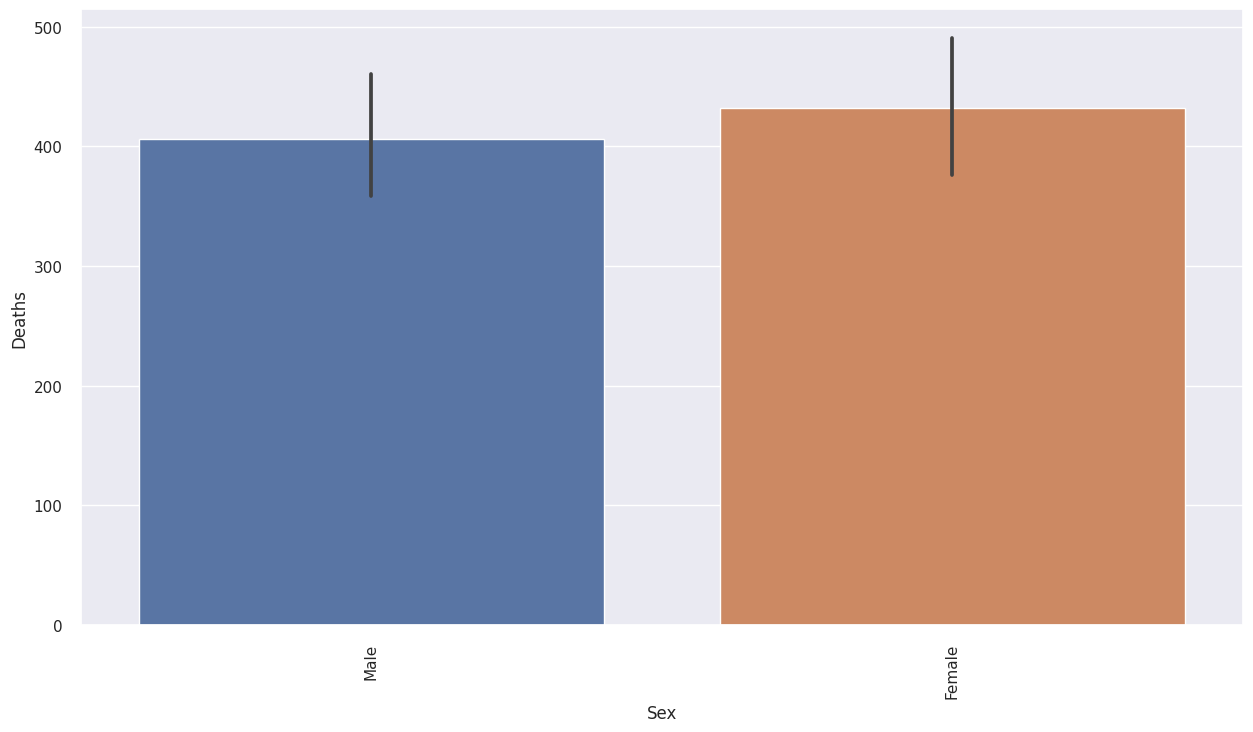

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data=df3, x='Sex', y='Deaths')
plt.xticks(rotation=90)
plt.show()

More female deaths by a little bit. 

**Year and Deaths**

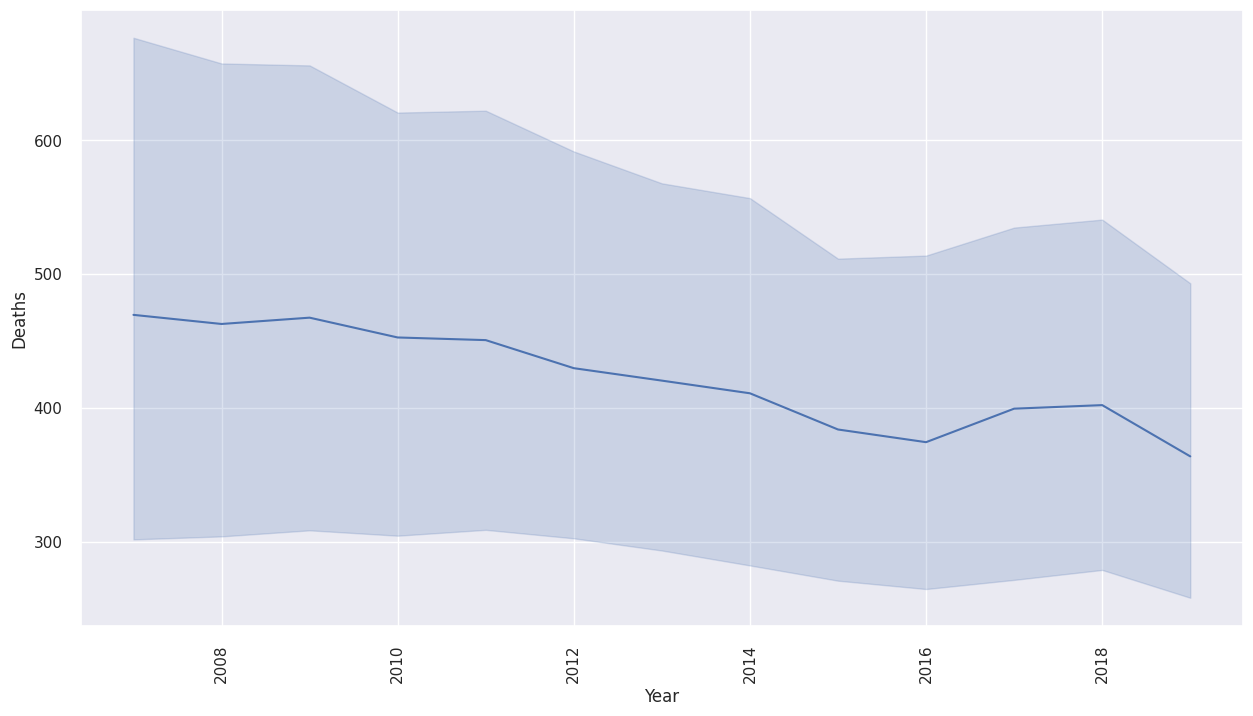

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df3, x='Year', y='Deaths')
plt.xticks(rotation=90)
plt.show()

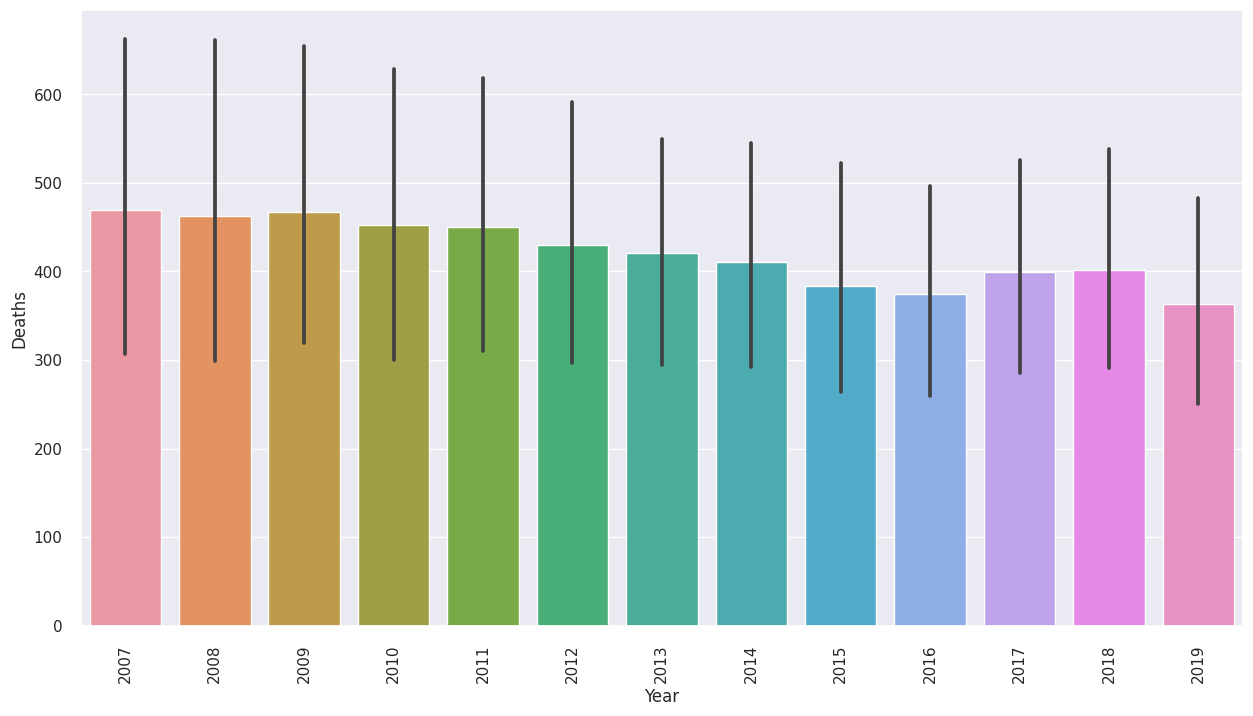

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data=df3, x='Year', y='Deaths')
plt.xticks(rotation=90)
plt.show()

Deaths more or less seem to go down as the years progress. 

**Leading Cause and Race/Ethnicity** 

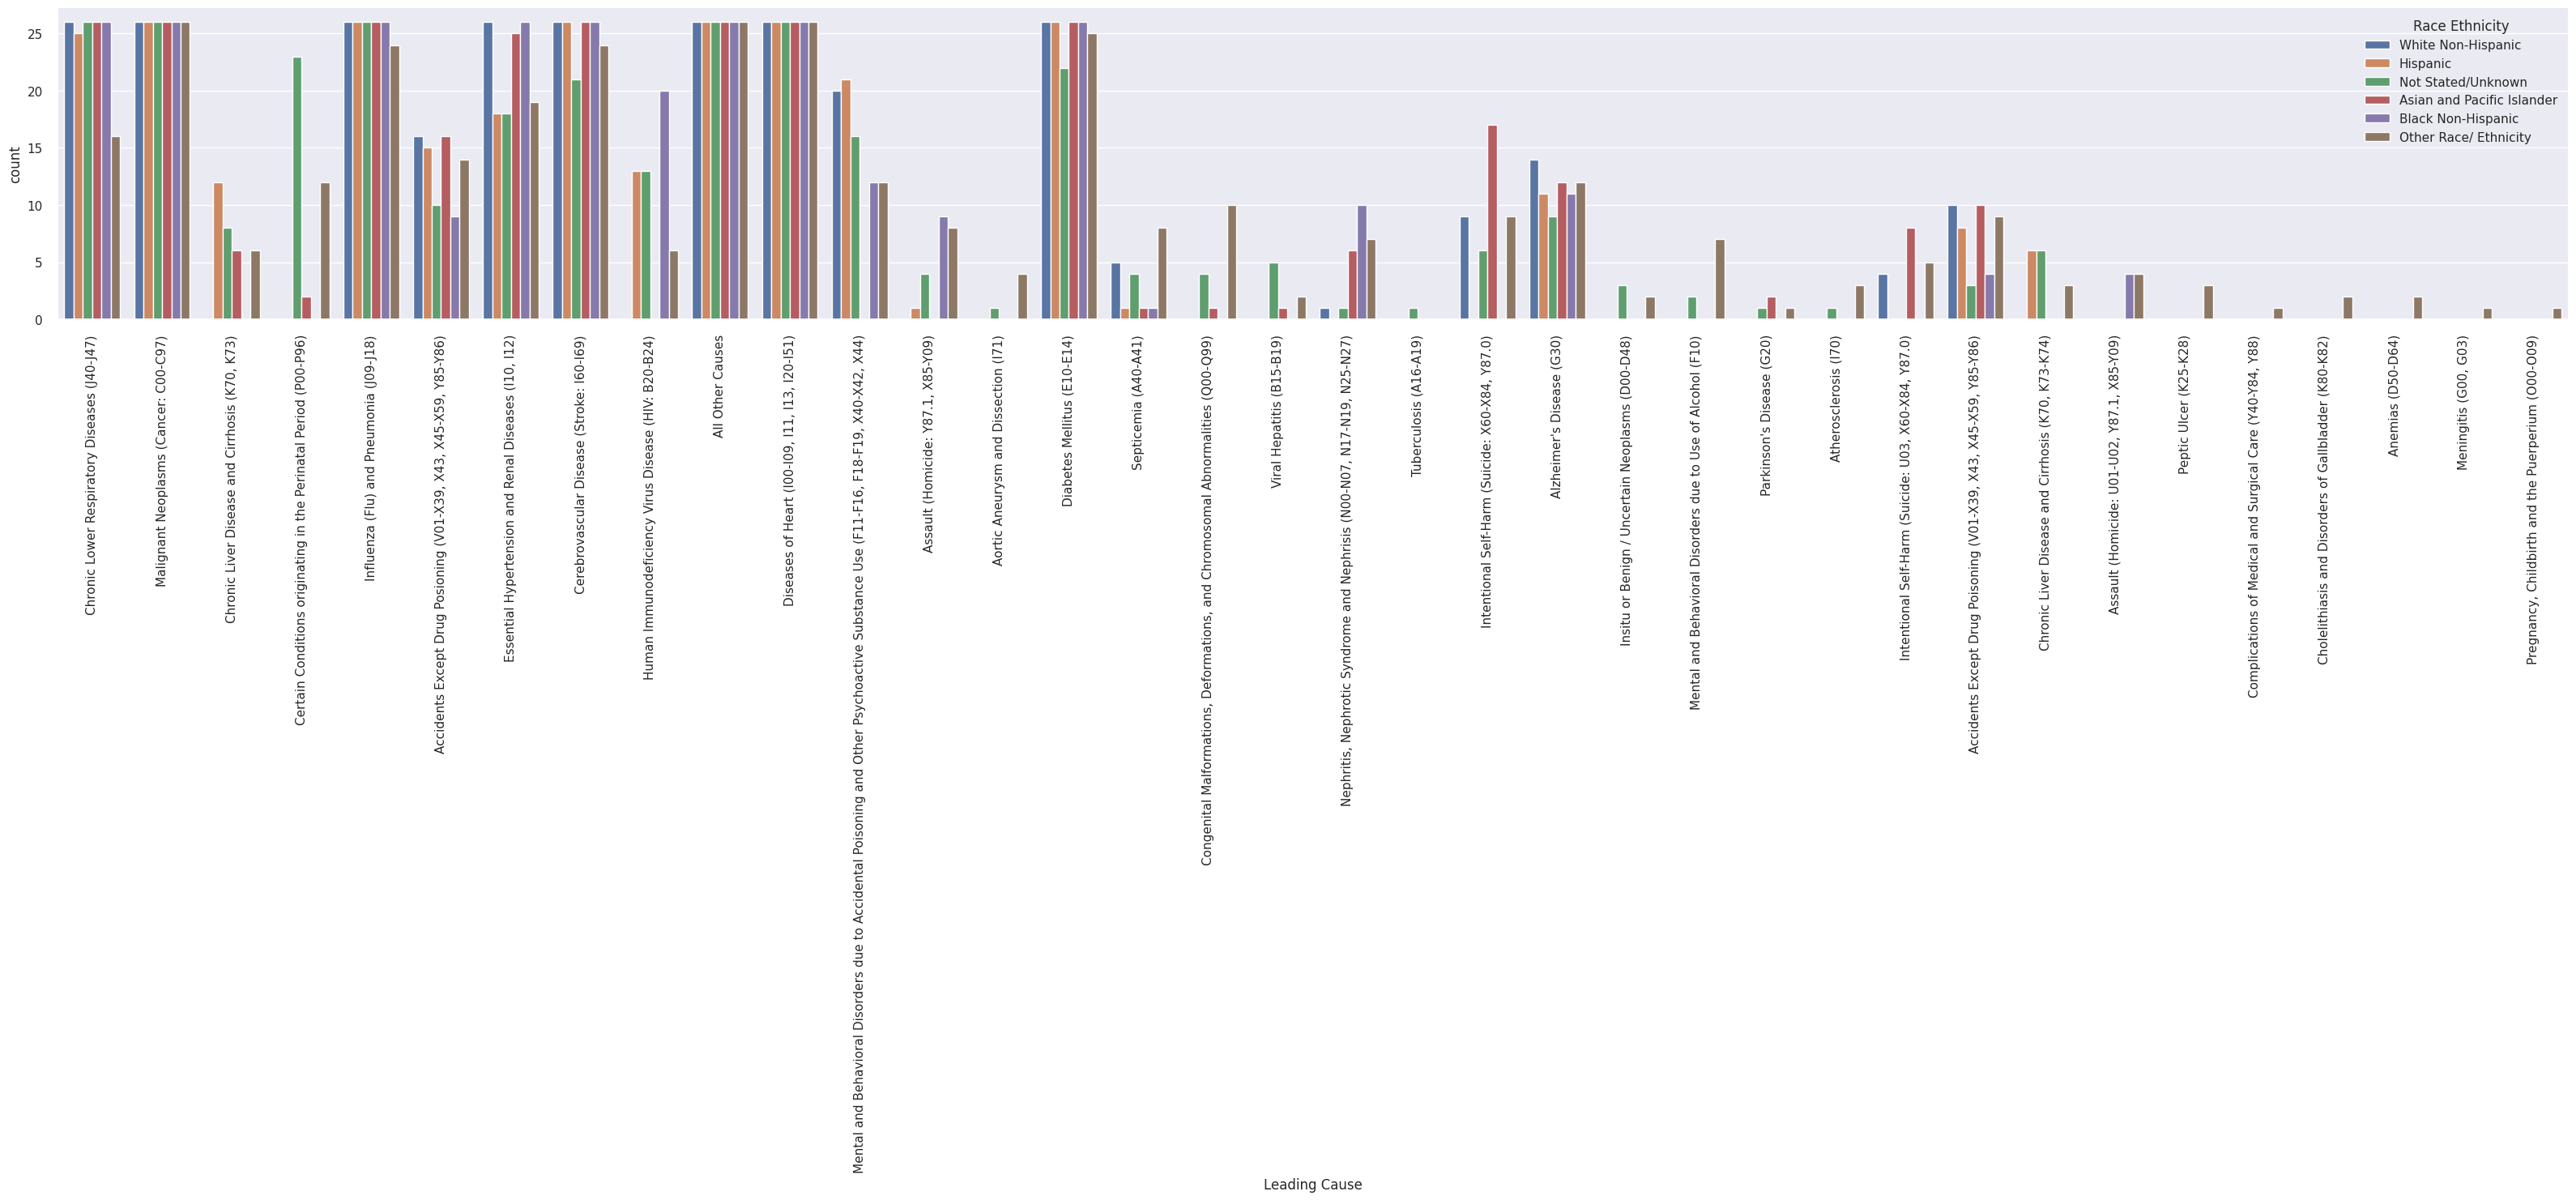

In [ ]:
plt.figure(figsize=(40,5))
sns.countplot(data=df3, x='Leading Cause', hue='Race Ethnicity')
plt.xticks(rotation=90)
plt.show()


Leading causes that seem to be the same equally across Ethnicity/Races is as follows: Malignant Neoplasms (Cancer), All Other Causes, and Diseases of the Heart. Asian and Pacific Islander have higher suicide cause of death than their counterparts. 

##**Conclusions, Insights, and Future Study**

**Limitations**
This data provided insights into sex and race/ethnicity in terms of leading cause of death and death counts in NYC. There are some limitations as this info is from 2007 to 2019. 

This dataset lacked a specific section under Leading Cause for COVID-19--It would be impactful to break this data down further and find out where COVID-19 lies in the death causes in NYC. 

Also, gender identity and expression are worth exploring for the "Sex" column. More data collection is needed for certain gender-identities (binary/non-binary) and/or sexualities (LGBT).

It is also worth noting that there was missing data in this dataset, but the missing data was a high enough percentage to not impute (could skew data further). 

**Insights and Future Study**
For the sake of this EDA, males had higher deaths related to assaults/homicide than females. 

Also, more females die each year than males in NYC (not by much though), but this should warrant more investigation. 

There are some notable disparities between sex and leading cause of death. Alzheimer's Disease seems to be a higher Leading Cause than in men. And unsurprisingly pregnancy related are only seen in the female sex. 

Some leading causes seem to be equal among sexes though: i.e. Leading Cause  Malignant Neoplasms (Cancer: C00-C97), Diseases of the Heart, Influensa (Flu), and All other causes. 

Moreover, for Race/Ethnicity: Not Stated/Unknown had a death rate of 17.3%, which is the higest of its counterparts, of which warrants further investigation/review. Additionally, Asians/Pacific Islanders had higher deaths related to suicide/self-harms, of which should be investigated. Leading causes that seem to be the same equally across Ethnicity/Races are as follows: Malignant Neoplasms (Cancer), All Other Causes, and Diseases of the Heart. Whites have the highest deaths in NYC according to this data. 

In terms of year: 2016 had the fewest deaths--needs further investigation.  

According to this dataset, deaths seem to be going down, but again it appears COVID data and more recent years are missing of which could have missed a spike in deaths.

